In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

pd.set_option('display.max_rows', None)

In [2]:
SEED = 888
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
df_read = pd.read_parquet('dataset_1B.parquet')
df_read.head()

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038


About Dataset

- date: Date of the assessment
- day: Day of the Week
- quarter: The quarter of the year when the data was recorded (e.g., Quarter1, Quarter2)
- Team Code: A unique identifier for the team.
- smv: Standard Minute Value, a measure of the time allocated for a task.
- wip: Work In Progress, the number of products that are unfinished.
- over_time: The amount of overtime worked, measured in minutes.
- incentive: The incentive provided to the workers, measured in USD.
- idle_time: The amount of time workers were idle, measured in minutes.
- idle_men: The number of workers who were idle.
- no_of_style_change: The number of style changes that occurred.
- no_of_workers: The total number of workers.
- productivity_score: The productivity score of the team, measured as a percentage.

### EDA

In [4]:
df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


Kolom 'date' memiliki tipe data yang salah dimana seharusnya merupakan date bukan object

In [5]:
df_read['date'].value_counts()

date
1/1/2015      12
1/24/2015     12
2/11/2015     12
2/10/2015     12
2/9/2015      12
2/8/2015      12
2/7/2015      12
2/5/2015      12
2/4/2015      12
2/3/2015      12
2/2/2015      12
2016-01-31    12
1/31/2015     12
1/29/2015     12
1/28/2015     12
1/27/2015     12
1/26/2015     12
2/12/2015     12
2/17/2015     12
2/18/2015     12
3/3/2015      12
3/11/2015     12
3/10/2015     12
3/9/2015      12
3/7/2015      12
3/5/2015      12
3/4/2015      12
3/2/2015      12
2/19/2015     12
3/1/2015      12
2/28/2015     12
2/26/2015     12
2/25/2015     12
2/24/2015     12
2/22/2015     12
1/25/2015     12
2016-03-10    12
1/6/2015      12
1/15/2015     12
1/5/2015      12
1/10/2015     12
1/14/2015     12
1/18/2015     12
1/13/2015     12
1/7/2015      12
1/19/2015     12
1/4/2015      12
1/17/2015     12
1/22/2015     12
1/12/2015     12
1/8/2015      12
1/21/2015     12
1/3/2015      12
1/11/2015     12
2/15/2015     11
2/16/2015     11
2016-01-12    11
2016-01-11    11
2/14/2015

- Dapat kita lihat jika format datenya tidak konsisten antara urutan tanggal, bulan, dan tahunnya. Seperatornya juga tidak konsisten ada yang / ada yang -
- Ada 2 format yaitu '%Y-%m-%d' dan '%m/%d/%Y'

In [6]:
# Fungsi untuk parsing dua format berbeda
def parse_mixed_date(val):
    try:
        return pd.to_datetime(val, format='%Y-%m-%d')
    except:
        try:
            return pd.to_datetime(val, format='%m/%d/%Y')
        except:
            return pd.NaT

df_read['date'] = df_read['date'].apply(parse_mixed_date)

# format ulang ke '%m/%d/%Y' string format
df_read['date'] = df_read['date'].dt.strftime('%m/%d/%Y')

In [7]:
df_read['date'].value_counts()

date
01/01/2015    12
01/24/2015    12
02/11/2015    12
02/10/2015    12
02/09/2015    12
02/08/2015    12
02/07/2015    12
02/05/2015    12
02/04/2015    12
02/03/2015    12
02/02/2015    12
01/31/2016    12
01/31/2015    12
01/29/2015    12
01/28/2015    12
01/27/2015    12
01/26/2015    12
02/12/2015    12
02/17/2015    12
02/18/2015    12
03/03/2015    12
03/11/2015    12
03/10/2015    12
03/09/2015    12
03/07/2015    12
03/05/2015    12
03/04/2015    12
03/02/2015    12
02/19/2015    12
03/01/2015    12
02/28/2015    12
02/26/2015    12
02/25/2015    12
02/24/2015    12
02/22/2015    12
01/25/2015    12
03/10/2016    12
01/06/2015    12
01/15/2015    12
01/05/2015    12
01/10/2015    12
01/14/2015    12
01/18/2015    12
01/13/2015    12
01/07/2015    12
01/19/2015    12
01/04/2015    12
01/17/2015    12
01/22/2015    12
01/12/2015    12
01/08/2015    12
01/21/2015    12
01/03/2015    12
01/11/2015    12
02/15/2015    11
02/16/2015    11
01/12/2016    11
01/11/2016    11
02/14/201

In [8]:
# Ubah format tanggal ke datetime
df_read['date'] = pd.to_datetime(df_read['date'], format='%m/%d/%Y')

In [9]:
df_read['quarter'].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

In [10]:
# Ekstrak angka dari string "QuarterX"
df_read['quarter'] = df_read['quarter'].str.extract('(\d+)').astype('int')

In [11]:
df_read.describe(exclude='object')

,date,quarter,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
count,1197,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,2015-07-05 16:49:19.398496256,2.399332,6.426901,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.337510,73.367040
min,2015-01-01 00:00:00,1.000000,1.000000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-57.000000,-100.000000
25%,2015-01-31 00:00:00,1.000000,3.000000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,65.030000
50%,2015-03-02 00:00:00,2.000000,6.000000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,77.333000
75%,2016-01-27 00:00:00,3.000000,9.000000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,85.025000
max,2016-03-10 00:00:00,5.000000,12.000000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,112.044000
std,NaN,1.215535,3.463963,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.617043,18.154945


In [12]:
df_read.describe(include='object')

,day
count,1197
unique,6
top,Wednesday
freq,208


Masalah:
- Kolom 'productivity_score' memiliki nilai minus

In [13]:
df_read[df_read['productivity_score']<0].shape[0]

1

Ada 1 row data yang memiliki value kolom 'productivity_score" yang negative

In [14]:
df_raw = df_read.copy()

In [15]:
# Menghapus unique identifier karena tidak diperlukan
df_raw = df_raw.drop(columns=['Team Code'])
df_raw.columns

Index(['date', 'quarter', 'day', 'smv', 'wip', 'over_time', 'incentive',
       'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
       'productivity_score'],
      dtype='object')

In [16]:
# Menghilangkan duplicate row
print("Number of duplicated rows:", df_raw.duplicated().sum())
df_raw = df_raw.drop_duplicates()

Number of duplicated rows: 17


In [17]:
print("Number of NaNs:", df_raw.isna().sum().sum())
print(df_raw.isna().sum()/df_raw.shape[0] * 100)

Number of NaNs: 490
date                   0.000000
quarter                0.000000
day                    0.000000
smv                    0.000000
wip                   41.525424
over_time              0.000000
incentive              0.000000
idle_time              0.000000
idle_men               0.000000
no_of_style_change     0.000000
no_of_workers          0.000000
productivity_score     0.000000
dtype: float64


Kolom 'wip' memiliki Nan lebih dari 40% sehingga akan dihapus

In [18]:
df_raw = df_raw.drop(columns='wip')

In [19]:
categorical_cols = df_raw.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['day']
Numerical columns: ['smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'productivity_score']


In [20]:
for col in categorical_cols:
    print(f'{col}: {df_raw[col].nunique()}')
    print(df_raw[col].value_counts())

day: 6
day
Wednesday    206
Sunday       201
Tuesday      199
Monday       197
Thursday     196
Saturday     181
Name: count, dtype: int64


In [21]:
# Drop kolom 'quarter' yang bernilai lebih dari 4 karena tidak logis
df_raw = df_raw[df_raw['quarter']<=4]

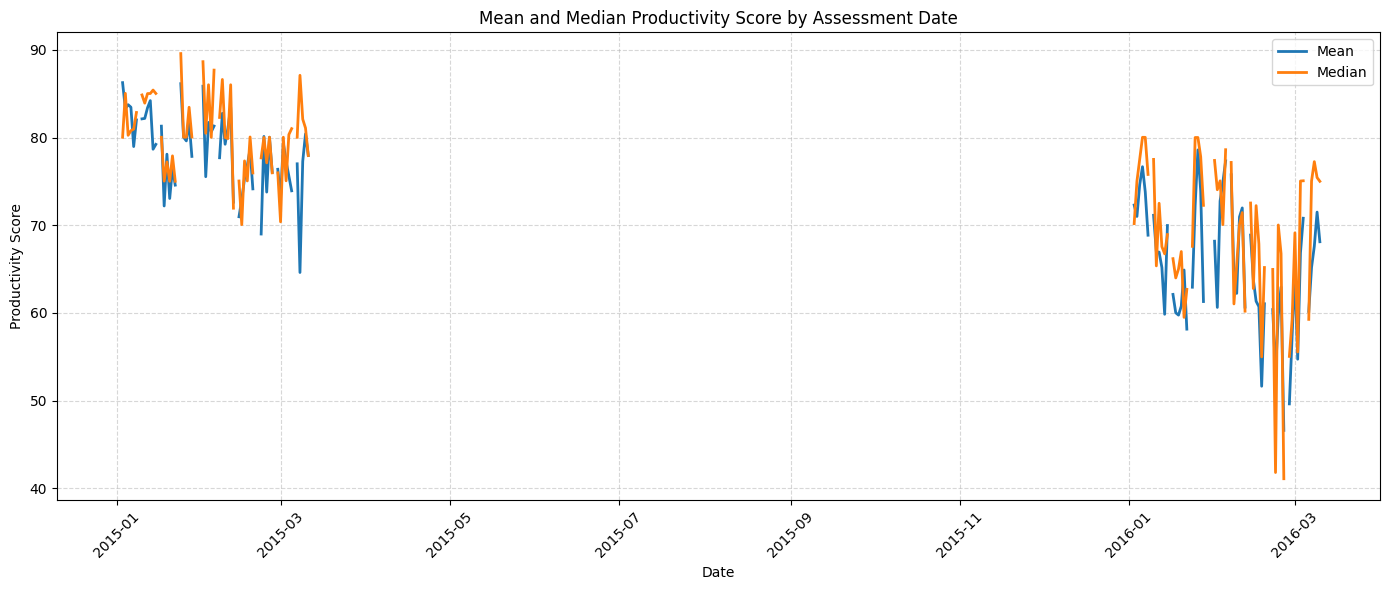

In [22]:
# Hitung mean & median per tanggal
daily_stats = df_raw.groupby('date')['productivity_score'].agg(['mean', 'median']).reset_index()
# Buat range tanggal lengkap
full_dates = pd.DataFrame({'date': pd.date_range(start=df_raw['date'].min(), end=df_raw['date'].max())})
# Merge agar tanggal kosong tetap muncul
daily_stats = full_dates.merge(daily_stats, on='date', how='left')

plt.figure(figsize=(14, 6))
plt.plot(daily_stats['date'], daily_stats['mean'], label='Mean', linewidth=2)
plt.plot(daily_stats['date'], daily_stats['median'], label='Median', linewidth=2)
plt.title('Mean and Median Productivity Score by Assessment Date')
plt.xlabel('Date')
plt.ylabel('Productivity Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [23]:
# Make sure 'date' is datetime
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Extract into new columns
df_raw['day_assessment'] = df_raw['date'].dt.day
df_raw['month_assessment'] = df_raw['date'].dt.month
df_raw['year_assessment'] = df_raw['date'].dt.year

# Drop original 'date' column
df_raw.drop(columns='date', inplace=True)
numerical_cols.extend(['day_assessment', 'month_assessment', 'year_assessment'])
print("Updated numerical columns:", numerical_cols)

Updated numerical columns: ['smv', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'productivity_score', 'day_assessment', 'month_assessment', 'year_assessment']


Graph: smv


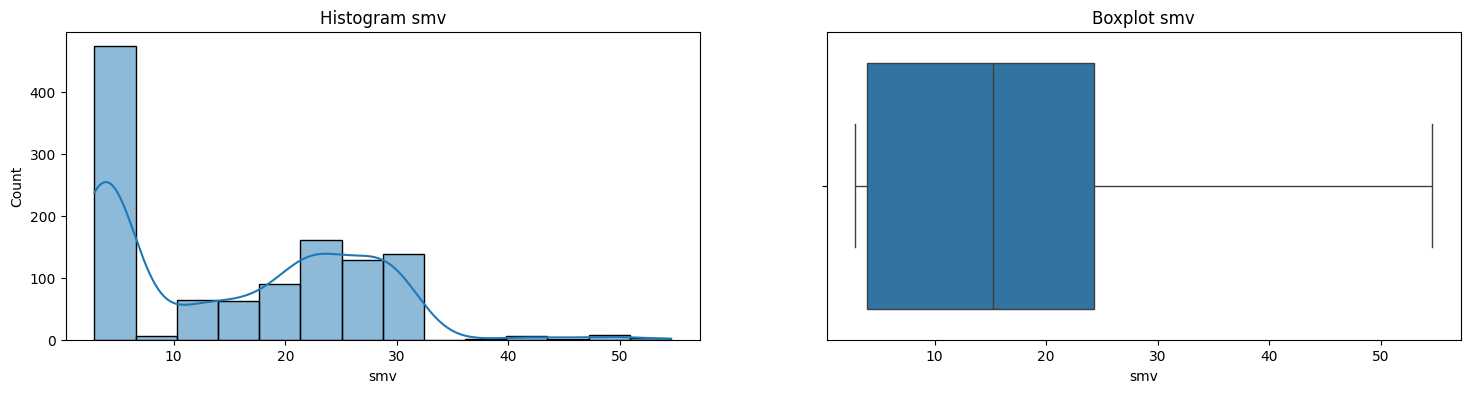

Skewness: 0.37375
Kurtosis: -0.85133


Graph: over_time


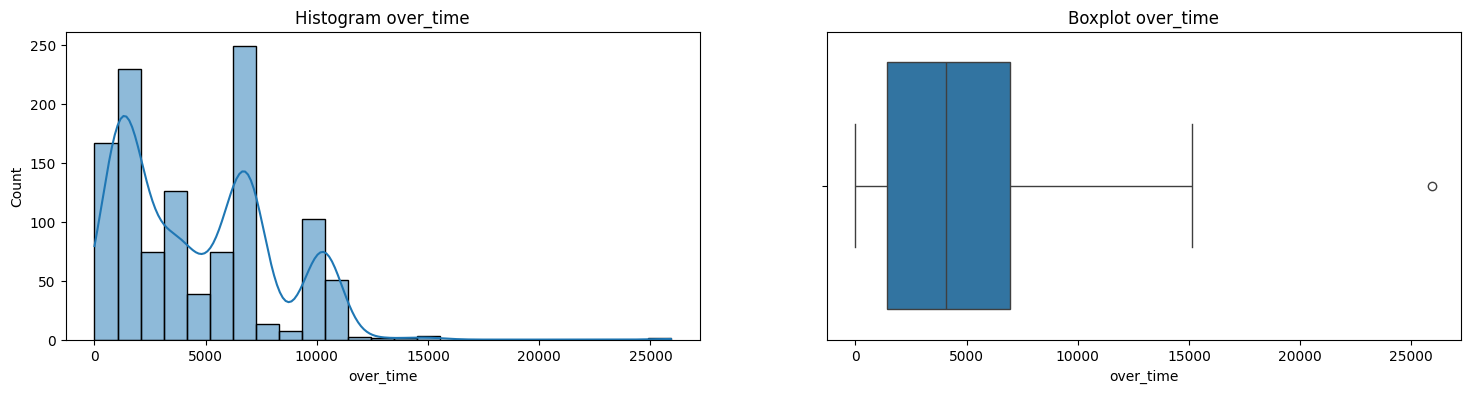

Skewness: 0.65375
Kurtosis: 0.40165


Graph: incentive


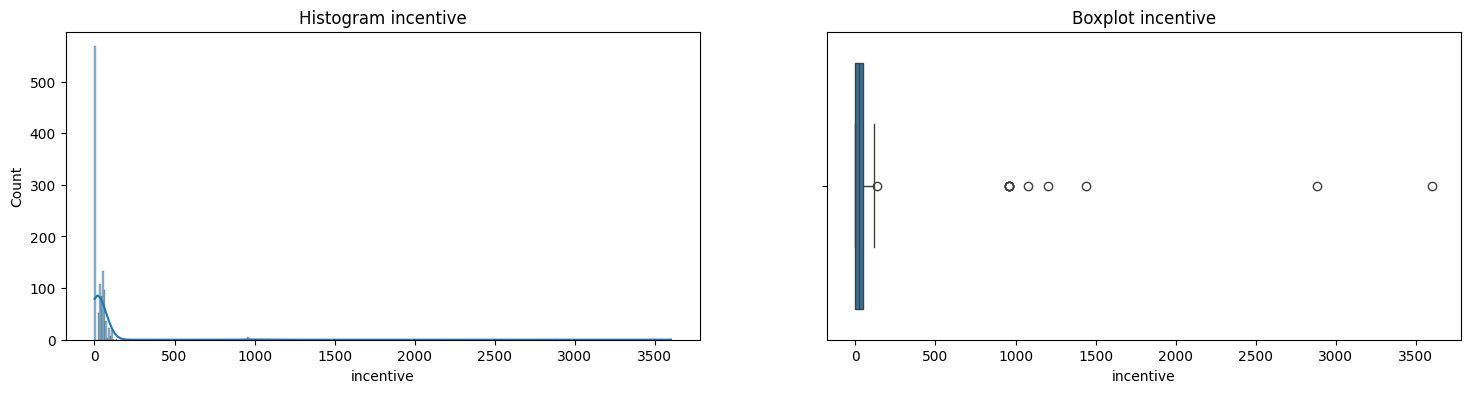

Skewness: 15.47046
Kurtosis: 286.23359


Graph: idle_time


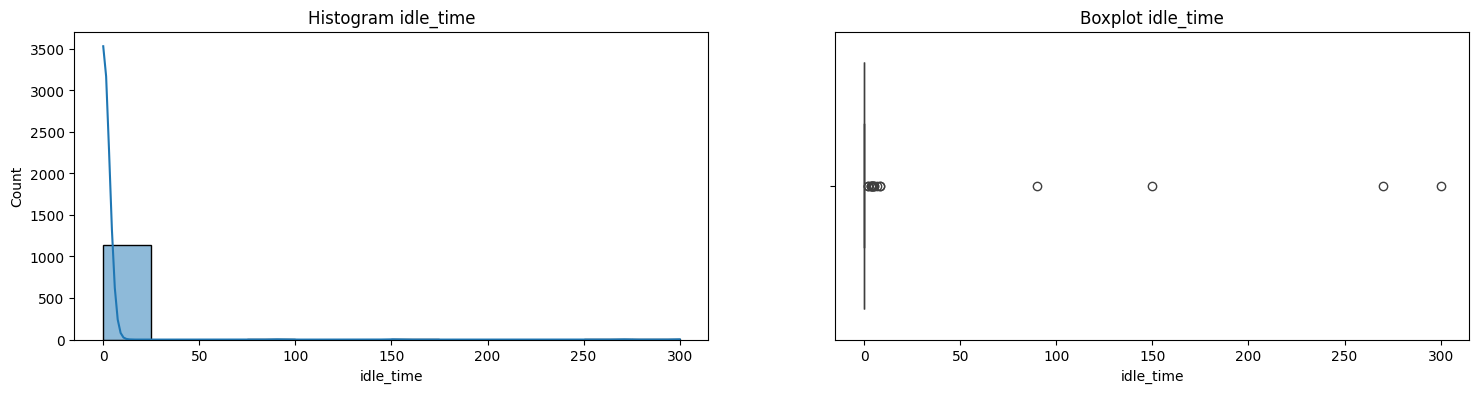

Skewness: 20.04809
Kurtosis: 421.41999


Graph: idle_men


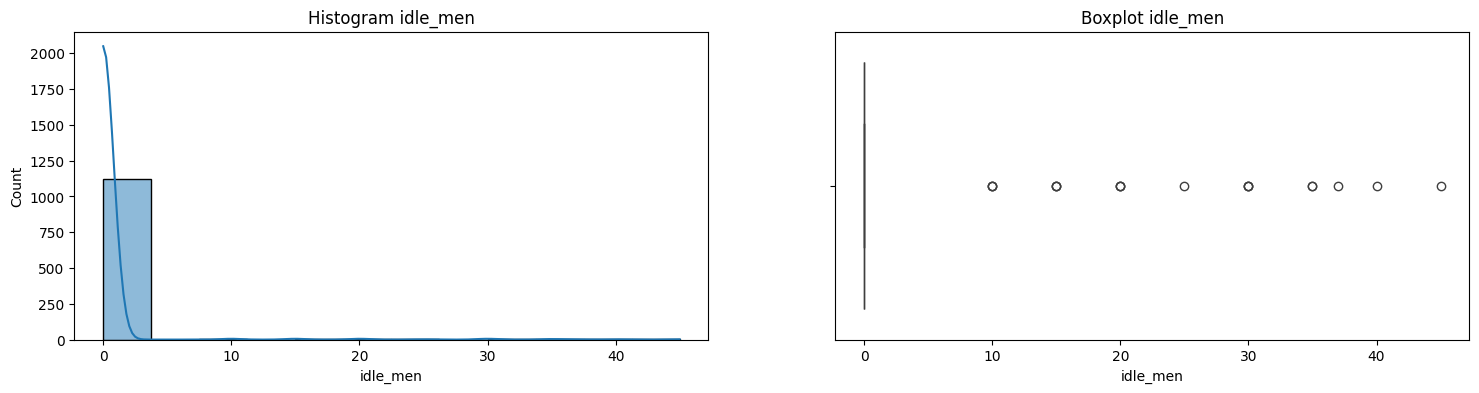

Skewness: 9.61089
Kurtosis: 97.85354


Graph: no_of_style_change


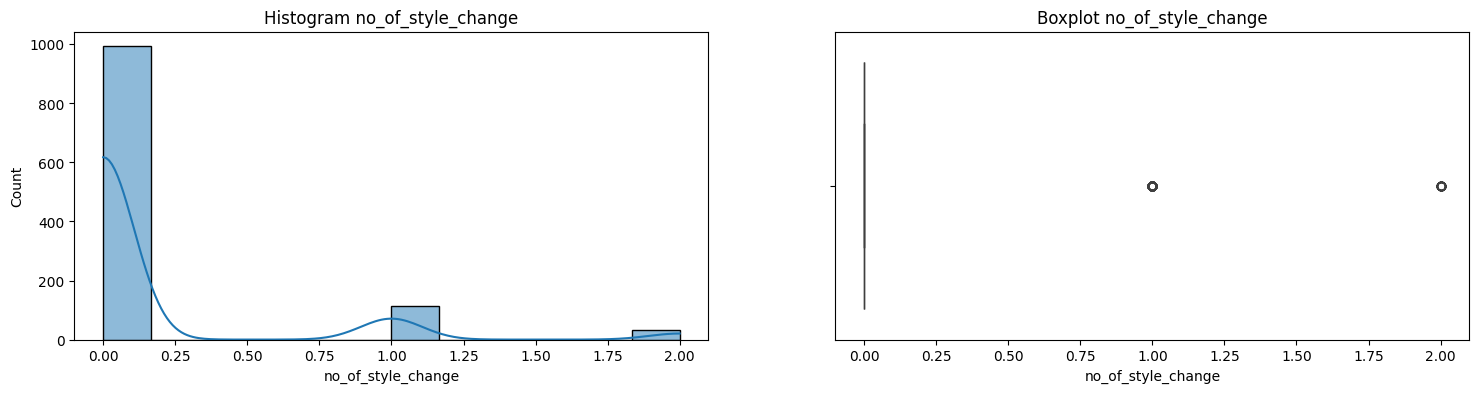

Skewness: 2.84895
Kurtosis: 7.58432


Graph: no_of_workers


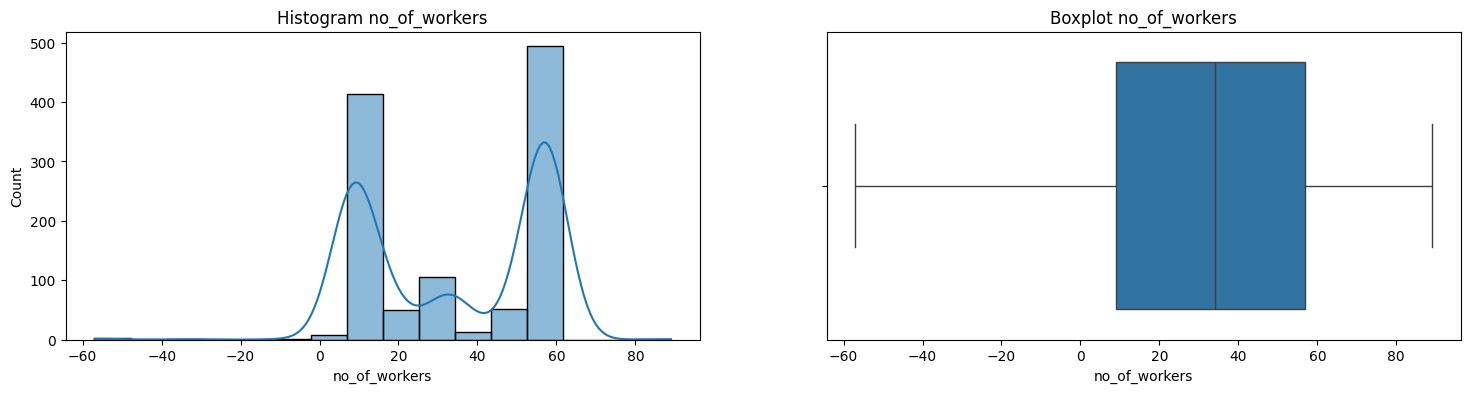

Skewness: -0.24181
Kurtosis: -1.32949


Graph: productivity_score


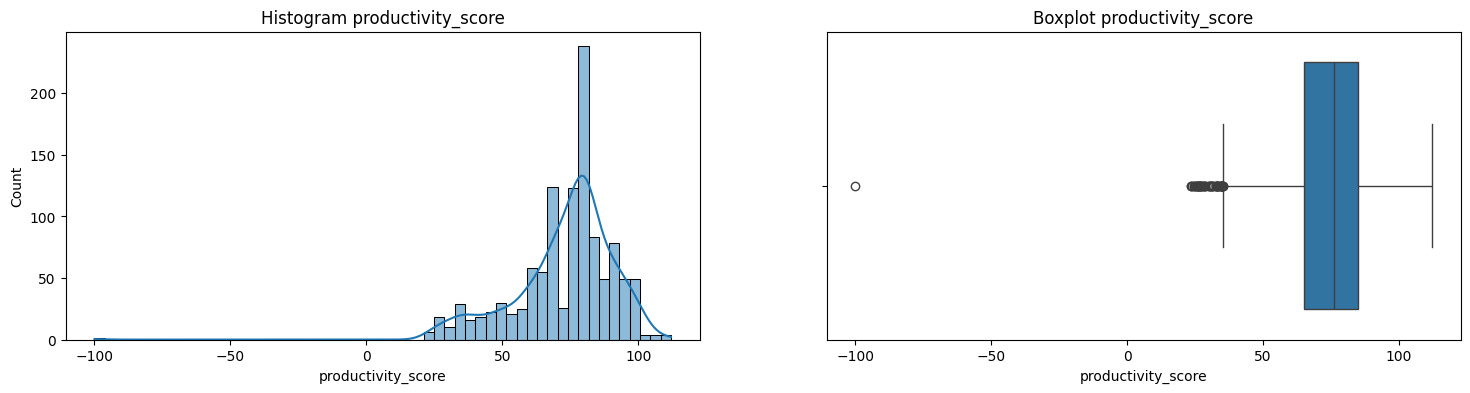

Skewness: -1.47813
Kurtosis: 7.30491


Graph: day_assessment


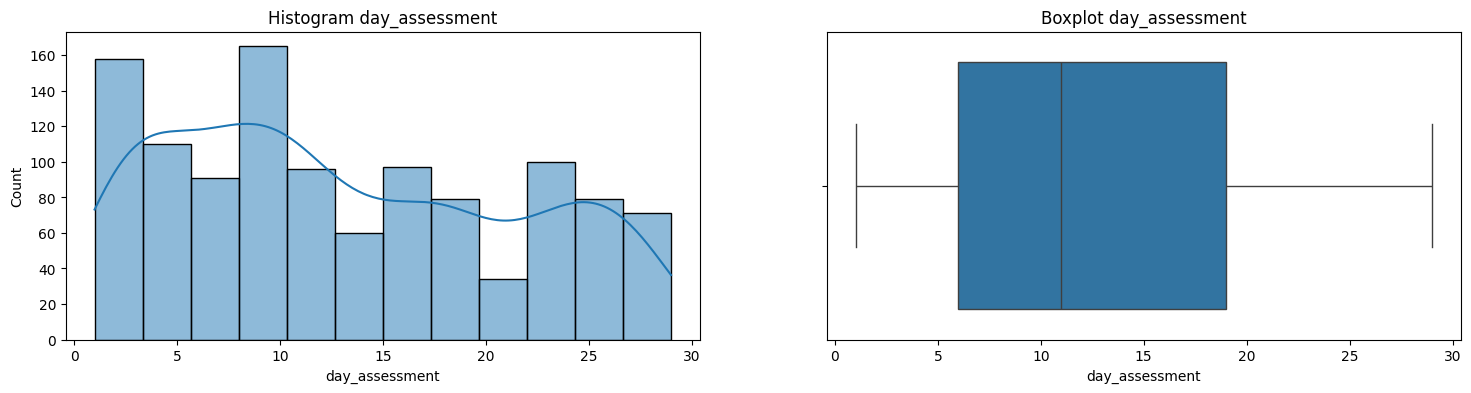

Skewness: 0.31821
Kurtosis: -1.12235


Graph: month_assessment


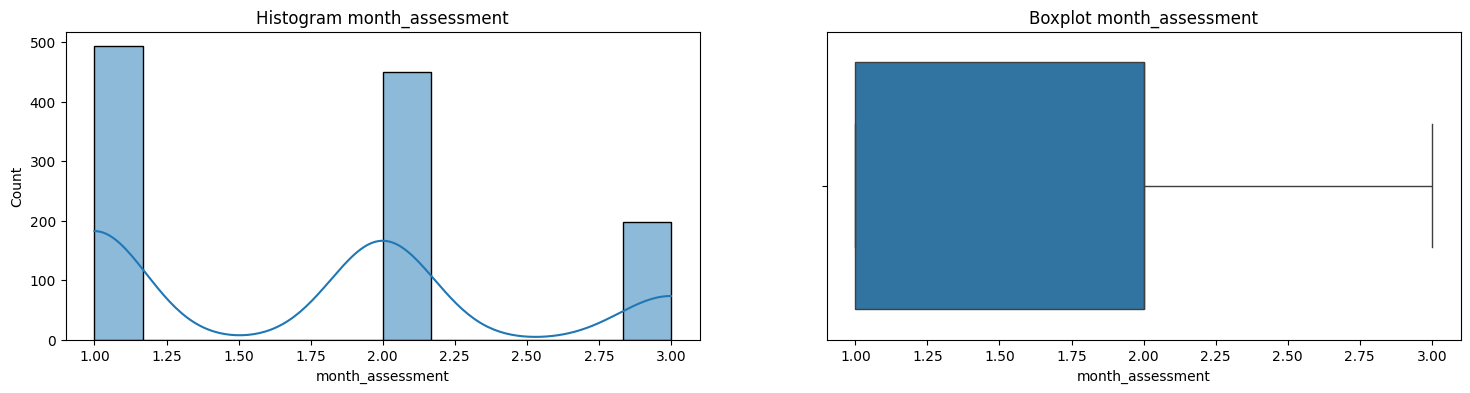

Skewness: 0.44798
Kurtosis: -1.04422


Graph: year_assessment


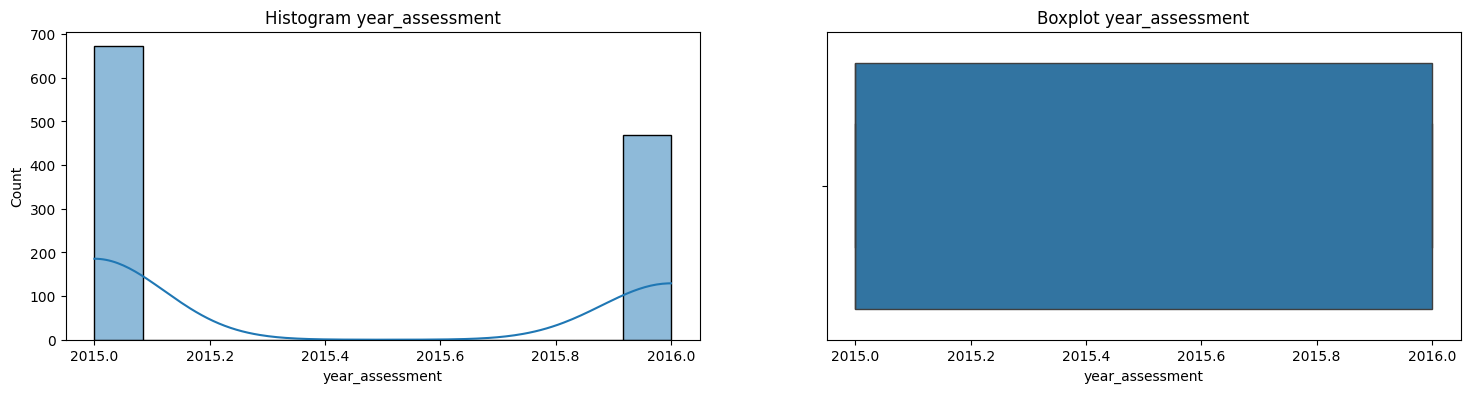

Skewness: 0.36425
Kurtosis: -1.87061




In [24]:
def print_distribution(df, cols):
    for col in cols:
        print("Graph:", col)

        # Figure to print histogram and boxplot side by side
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))

        # Histogram
        sns.histplot(df[col], kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram {col}')

        # Horizontal Boxplot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot {col}')

        plt.show()

        # Skewness and kurtosis
        print(f'Skewness: {df[col].skew():.5f}')
        print(f'Kurtosis: {df[col].kurt():.5f}\n\n')

print_distribution(df_raw, numerical_cols)

In [25]:
# Karena column 'productivity_score' memiliki distribusi tidak normal, maka kita akan mengimpute nilai negatifnya dengan nilai median
df = df_raw.copy()

mean_productivity_score = df['productivity_score'].median()
df['productivity_score'] = df['productivity_score'].apply(lambda x: mean_productivity_score if x < 0 else x)

In [26]:
def hitung_outlier(df, numerical_cols):
    outlier_counts = {}

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]

    # Tampilkan hasil
    for col, count in outlier_counts.items():
        print(f"{col}: {count} row -> {count/df.shape[0]*100:.2f}%")

hitung_outlier(df, numerical_cols)

smv: 0 row -> 0.00%
over_time: 1 row -> 0.09%
incentive: 11 row -> 0.96%
idle_time: 18 row -> 1.58%
idle_men: 18 row -> 1.58%
no_of_style_change: 147 row -> 12.89%
no_of_workers: 0 row -> 0.00%
productivity_score: 56 row -> 4.91%
day_assessment: 0 row -> 0.00%
month_assessment: 0 row -> 0.00%
year_assessment: 0 row -> 0.00%


In [27]:
# Kolom target: hanya yang outliernya < 2%
cols_to_winsor = ['over_time', 'incentive', 'idle_time', 'idle_men']

for col in cols_to_winsor:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers dengan batas
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


smv: 0 row -> 0.00%
over_time: 0 row -> 0.00%
incentive: 0 row -> 0.00%
idle_time: 0 row -> 0.00%
idle_men: 0 row -> 0.00%
no_of_style_change: 147 row -> 12.89%
no_of_workers: 0 row -> 0.00%
productivity_score: 56 row -> 4.91%
day_assessment: 0 row -> 0.00%
month_assessment: 0 row -> 0.00%
year_assessment: 0 row -> 0.00%
Graph: smv


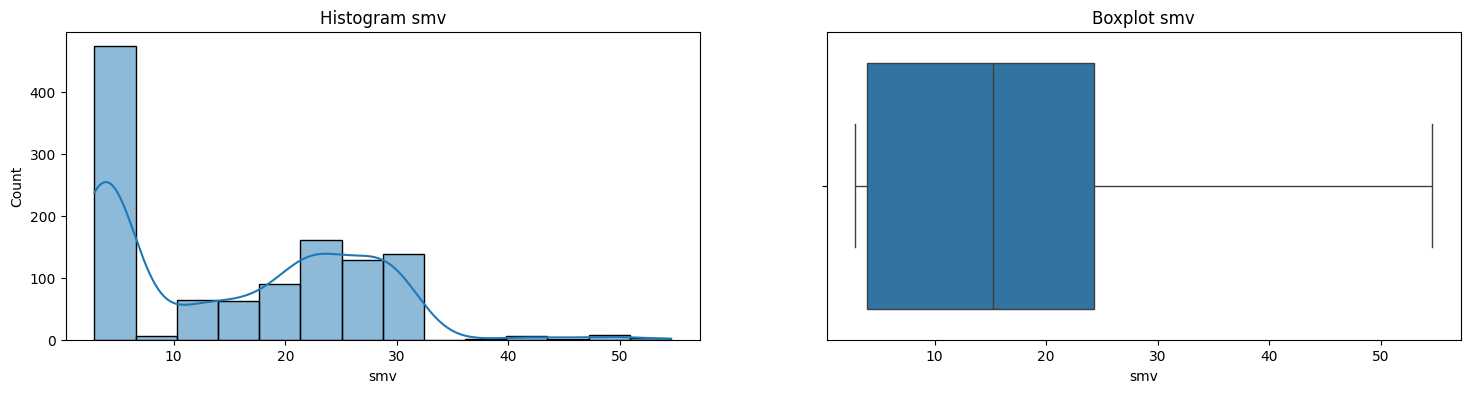

Skewness: 0.37375
Kurtosis: -0.85133


Graph: over_time


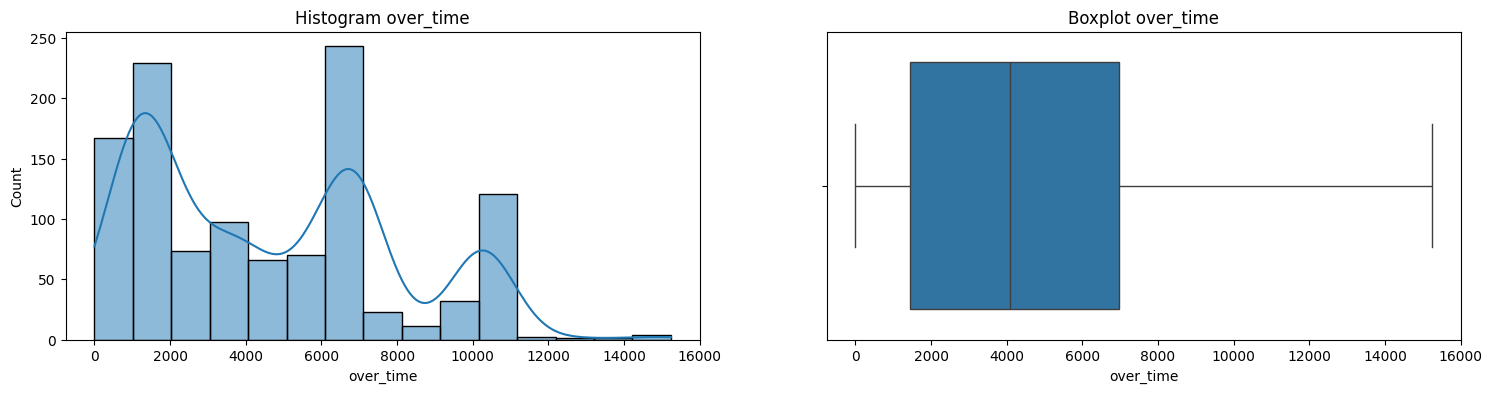

Skewness: 0.48417
Kurtosis: -0.82153


Graph: incentive


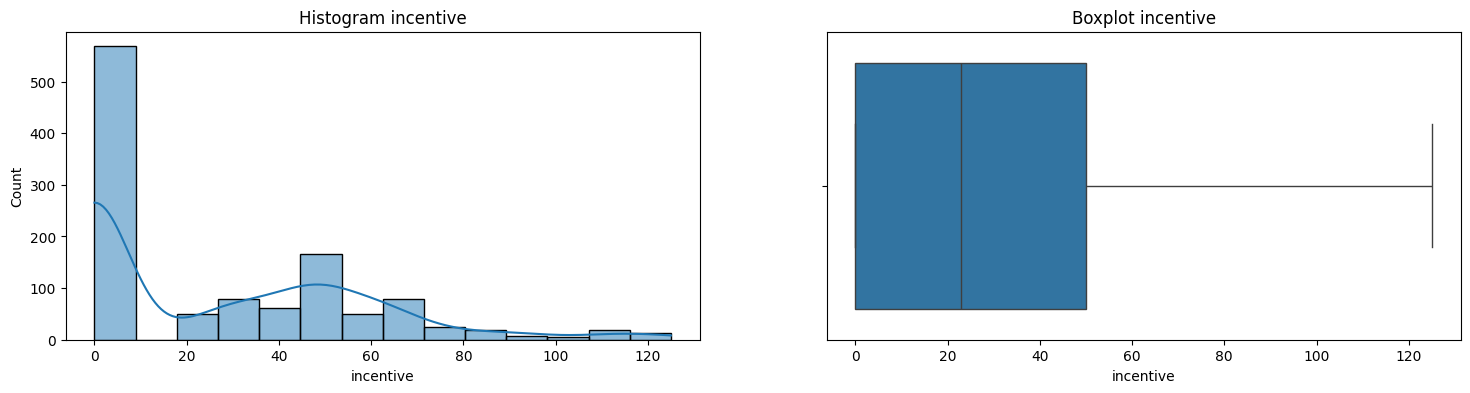

Skewness: 0.92731
Kurtosis: 0.18658


Graph: idle_time


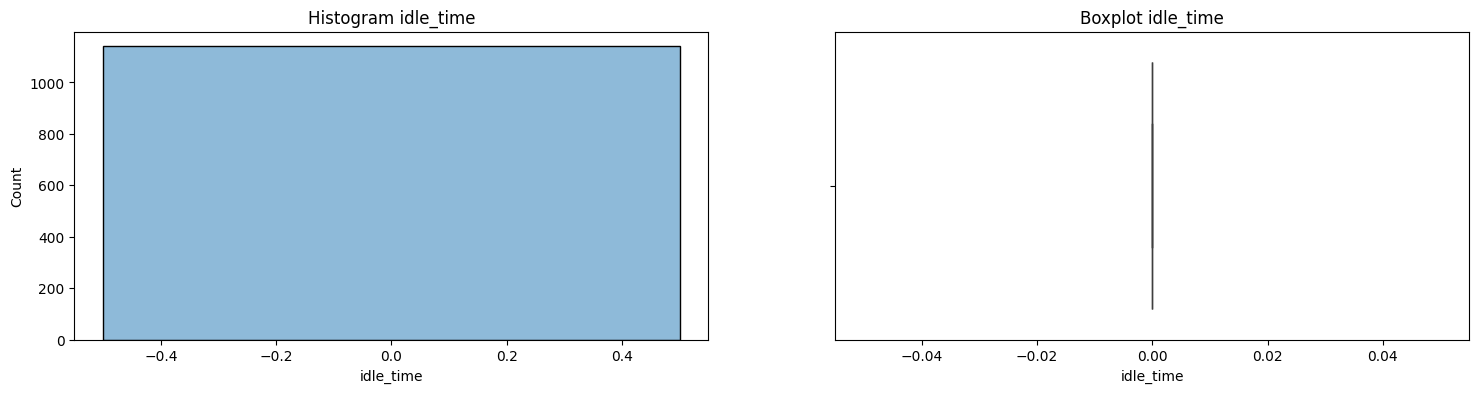

Skewness: 0.00000
Kurtosis: 0.00000


Graph: idle_men


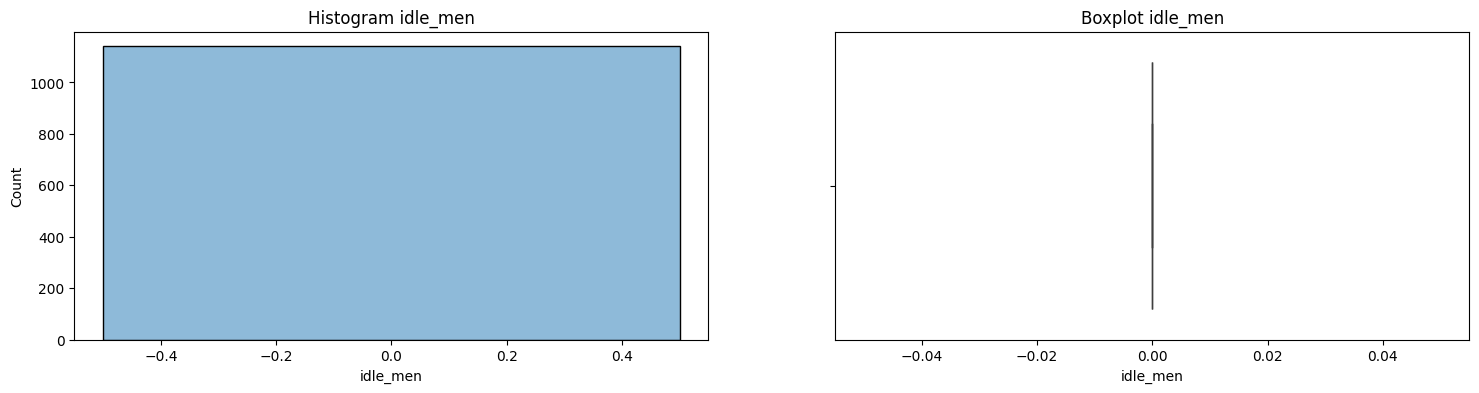

Skewness: 0.00000
Kurtosis: 0.00000


Graph: no_of_style_change


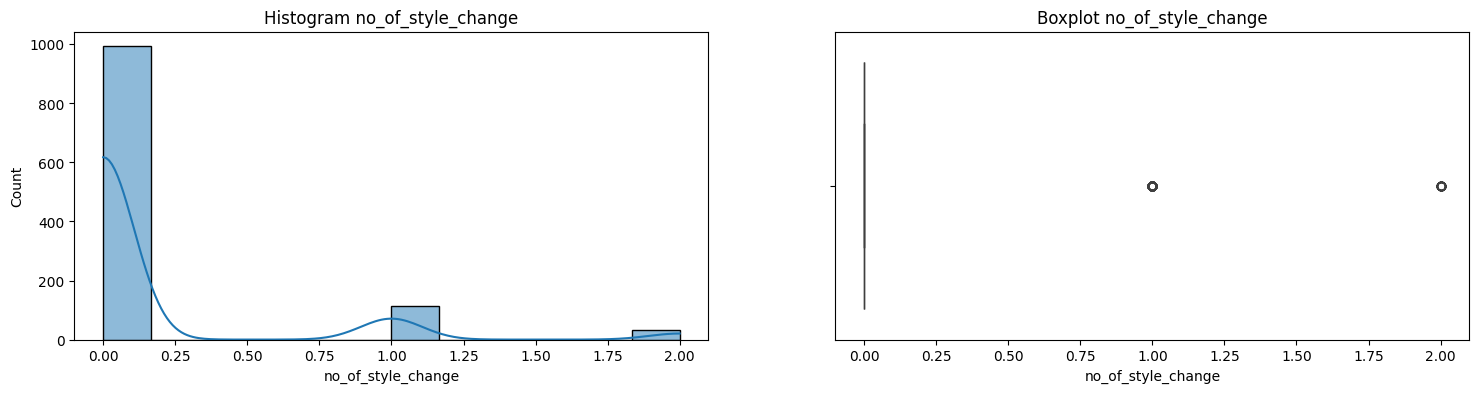

Skewness: 2.84895
Kurtosis: 7.58432


Graph: no_of_workers


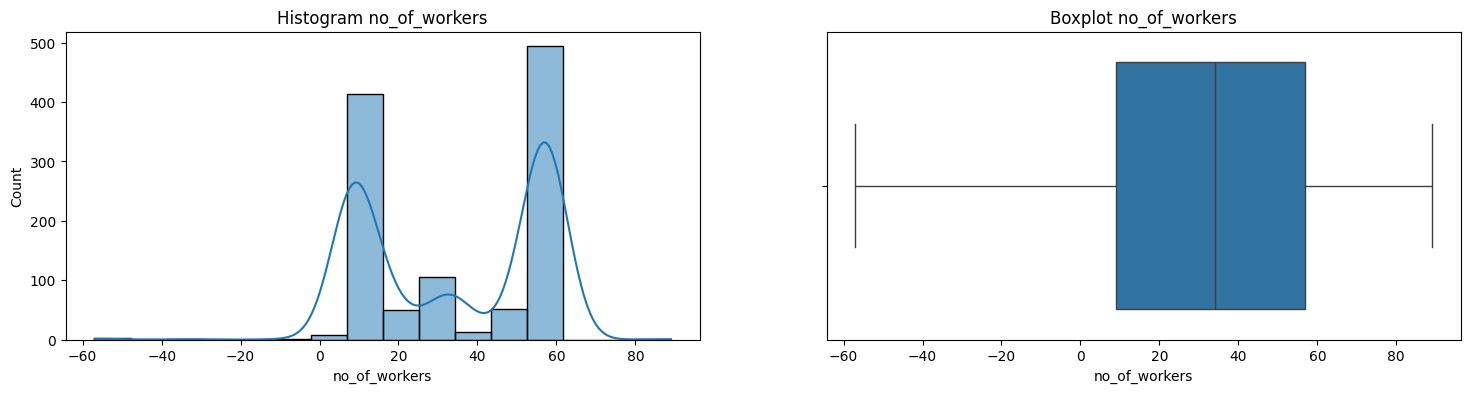

Skewness: -0.24181
Kurtosis: -1.32949


Graph: productivity_score


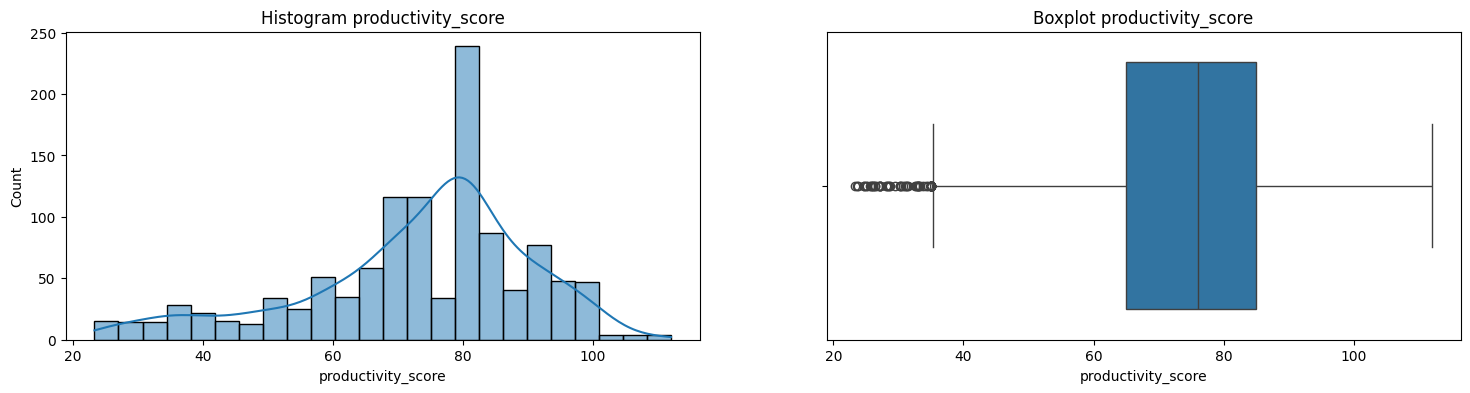

Skewness: -0.82436
Kurtosis: 0.39844


Graph: day_assessment


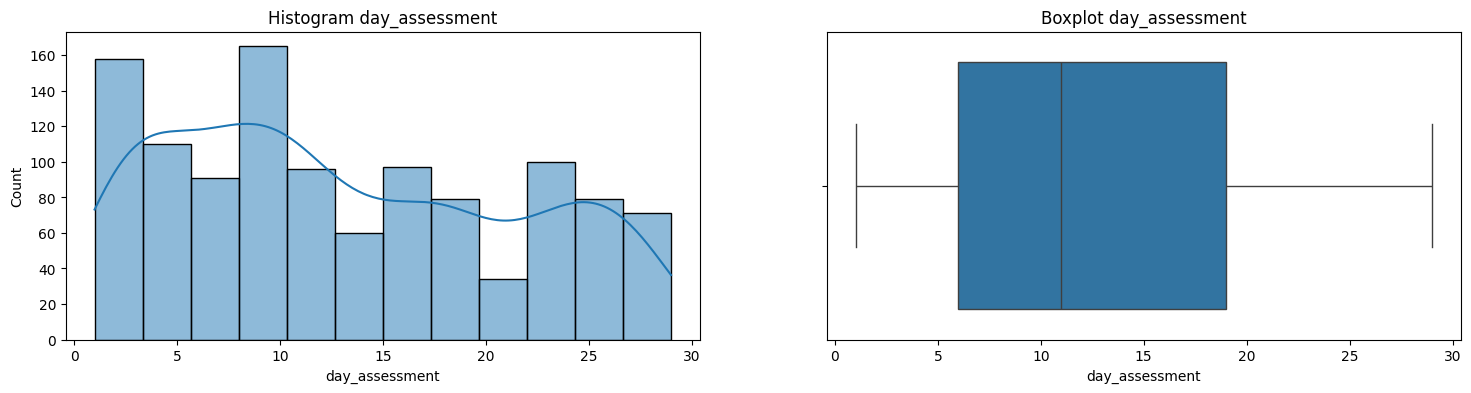

Skewness: 0.31821
Kurtosis: -1.12235


Graph: month_assessment


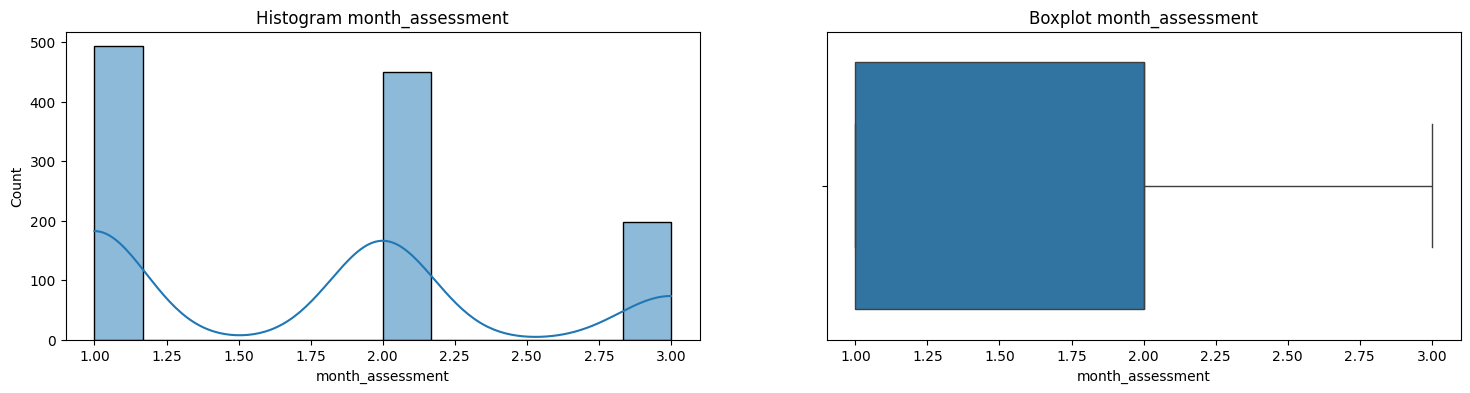

Skewness: 0.44798
Kurtosis: -1.04422


Graph: year_assessment


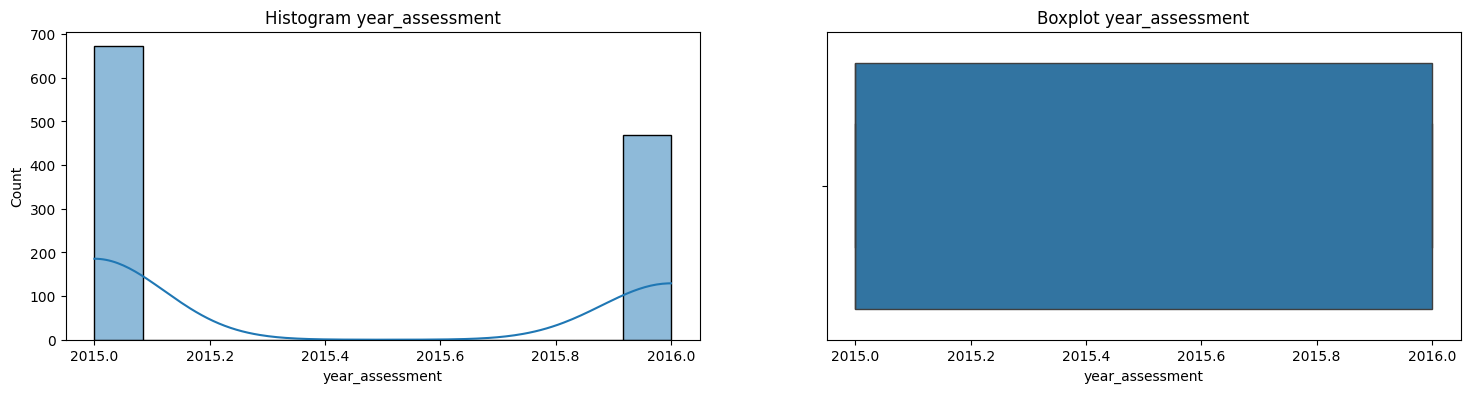

Skewness: 0.36425
Kurtosis: -1.87061




In [28]:
hitung_outlier(df, numerical_cols)
print_distribution(df, numerical_cols)

Kolom 'productivity_score' tidak akan ditangani outlier-nya karena nilai ekstrem pada kolom ini masih dianggap wajar dan dapat terjadi secara alami dalam hal produktivitas

In [29]:
print(df['idle_men'].value_counts())
print(df['idle_time'].value_counts())

idle_men
0    1140
Name: count, dtype: int64
idle_time
0.0    1140
Name: count, dtype: int64


Kedua kolom diatas hanya mrmiliki 1 nilai yang sama yaitu 0

In [30]:
df = df.drop(columns=['idle_men', 'idle_time'])
numerical_cols.remove('idle_men')
numerical_cols.remove('idle_time')

print(df.columns)
print(f"Numerical columns: {numerical_cols}")

Index(['quarter', 'day', 'smv', 'over_time', 'incentive', 'no_of_style_change',
       'no_of_workers', 'productivity_score', 'day_assessment',
       'month_assessment', 'year_assessment'],
      dtype='object')
Numerical columns: ['smv', 'over_time', 'incentive', 'no_of_style_change', 'no_of_workers', 'productivity_score', 'day_assessment', 'month_assessment', 'year_assessment']


In [31]:
df[df['productivity_score']<=0].shape[0]

0

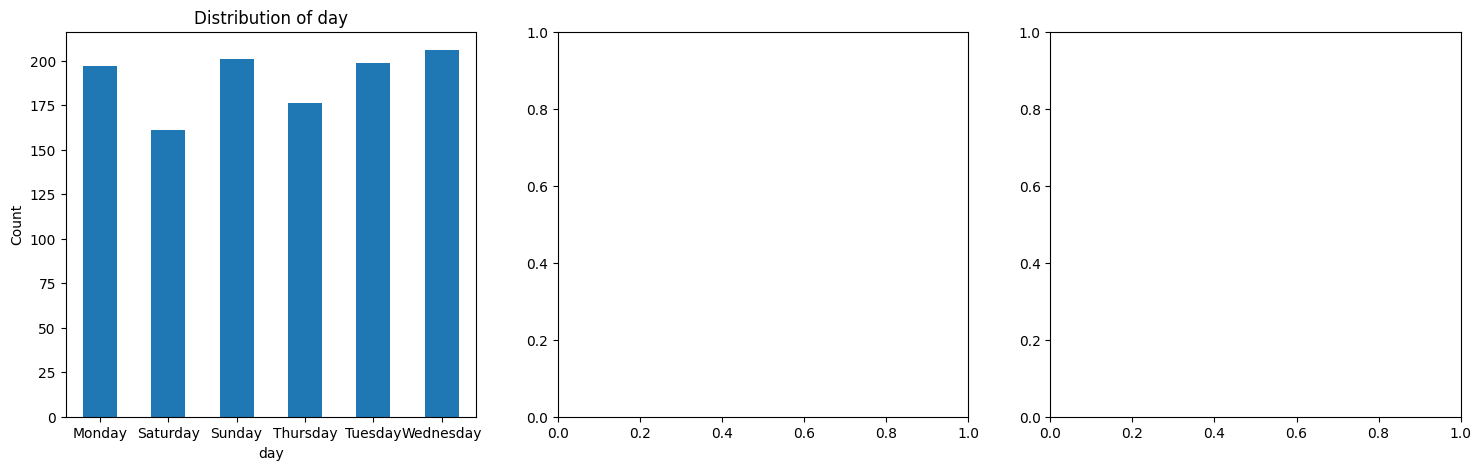

In [32]:
def distribution_categorical(df, columns):
    import matplotlib.pyplot as plt

    n_cols = 3
    n_rows = math.ceil(len(columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

    for idx, col in enumerate(columns):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
        df[col].value_counts().sort_index().plot(kind='bar', ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=0)
        # ax.grid(axis='y', linestyle='--', alpha=0.7)

distribution_categorical(df, categorical_cols)

### Data Splitting

In [33]:
X = df.drop(columns=['productivity_score'])
y = df['productivity_score']
numerical_cols.remove('productivity_score')

In [34]:
from sklearn.model_selection import train_test_split

# Step 1: Split 20% test dari data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)

# Step 2: Split sisa 80% menjadi 70% train dan 10% val
# Artinya: val = 10/80 = 0.125 dari X_temp
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125)

In [35]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(798, 10) (798,)
(114, 10) (114,)
(228, 10) (228,)


### Data Preprocessing

Scaling

In [36]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# standard_cols = ['Age', 'Experience']
robust_cols = numerical_cols

In [37]:
# # StandardScaler on normal, no outlier columns
# X_train[standard_cols] = standard_scaler.fit_transform(X_train[standard_cols])
# X_val[standard_cols] = standard_scaler.transform(X_val[standard_cols])
# X_test[standard_cols] = standard_scaler.transform(X_test[standard_cols])

# RobustScaler on skewed and outlier-prone columns
X_train[robust_cols] = robust_scaler.fit_transform(X_train[robust_cols])
X_val[robust_cols] = robust_scaler.transform(X_val[robust_cols])
X_test[robust_cols] = robust_scaler.transform(X_test[robust_cols])

In [38]:
scaler_y = RobustScaler()
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_val = scaler_y.transform(pd.DataFrame(y_val))
# y_test = scaler_y.transform(pd.DataFrame(y_test))

Encoding -> hampir semua column sudah berupa angka sehingga tidak perlu dilakukan encoding, kecuali untuk column 'ZIP Code'

In [39]:
from sklearn.preprocessing import OneHotEncoder

# Initialize encoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on train, transform all sets
train_encoded = ohe_encoder.fit_transform(X_train[['day']])
val_encoded = ohe_encoder.transform(X_val[['day']])
test_encoded = ohe_encoder.transform(X_test[['day']])

In [40]:
train_encoded

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [41]:
ohe_encoder.get_feature_names_out(['day'])

array(['day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday'], dtype=object)

In [42]:
# Convert to DataFrame with appropriate column names
train_encoded_df = pd.DataFrame(train_encoded, columns=ohe_encoder.get_feature_names_out(['day']), index=X_train.index)
val_encoded_df = pd.DataFrame(val_encoded, columns=ohe_encoder.get_feature_names_out(['day']), index=X_val.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=ohe_encoder.get_feature_names_out(['day']), index=X_test.index)

# Drop original column and concat encoded
X_train = pd.concat([X_train.drop(columns=['day']), train_encoded_df], axis=1)
X_val = pd.concat([X_val.drop(columns=['day']), val_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=['day']), test_encoded_df], axis=1)

In [43]:
# Drop one of the one-hot encoded ZIP_Group columns to avoid multicollinearity
col_to_drop = train_encoded_df.columns[0]

# Drop from all datasets
X_train = X_train.drop(columns=[col_to_drop])
X_val = X_val.drop(columns=[col_to_drop])
X_test = X_test.drop(columns=[col_to_drop])

In [44]:
X_train.columns

Index(['quarter', 'smv', 'over_time', 'incentive', 'no_of_style_change',
       'no_of_workers', 'day_assessment', 'month_assessment',
       'year_assessment', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday'],
      dtype='object')

Oversampling

### Modelling

In [45]:
import tensorflow.keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

metrics=['mae', rmse, 'mse']

In [46]:
input_dim = X_train.shape[1]
print("Num of columns:", input_dim)

Num of columns: 14


#### Function

In [47]:
def generate_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        CSVLogger(f'{model_name}.csv')
    ]

In [48]:
def plot_loss_curve(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [49]:
def eval_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # Print results
    print(f"R squared: {r2:.4f}")
    print(f"MSE      : {mse:.4f}")
    print(f"RMSE     : {rmse:.4f}")
    print(f"MAE      : {mae:.4f}")

    # Return as a DataFrame row
    return pd.DataFrame([{
        'model_name': model_name,
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae
    }])


#### Model Sequential 1

##### Define and Train Model

In [50]:
model_seq1 = Sequential([
    Input(shape=(input_dim,)),
    Dense(input_dim * 3, activation='relu'),
    Dense(input_dim * 2, activation='relu'),
    Dense(1)
])

In [51]:
model_seq1.compile(
    optimizer='adam',
    loss='mse',
    metrics=metrics
)

model_seq1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 42)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         1,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,863 (7.28 KB)

 Trainable params: 1,863 (7.28 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
callbacks_seq1 = generate_callbacks("model_seq1")

history_1 = model_seq1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_seq1,
    verbose=1
)

Epoch 1/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3773 - mae: 0.9734 - mse: 1.3773 - rmse: 1.1623
Epoch 1: val_loss improved from inf to 0.87278, saving model to model_seq1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.2609 - mae: 0.9206 - mse: 1.2609 - rmse: 1.1082 - val_loss: 0.8728 - val_mae: 0.6973 - val_mse: 0.8728 - val_rmse: 0.9541 - learning_rate: 0.0010
Epoch 2/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8079 - mae: 0.6817 - mse: 0.8079 - rmse: 0.8909
Epoch 2: val_loss improved from 0.87278 to 0.73231, saving model to model_seq1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7820 - mae: 0.6697 - mse: 0.7820 - rmse: 0.8760 - val_loss: 0.7323 - val_mae: 0.6455 - val_mse: 0.7323 - val_rmse: 0.8740 - learning_rate: 0.0010
Epoch 3/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6559 - mae: 0.6145 - mse: 0.6559 - rmse: 0.8032
Epoch 3: val_loss improved from 0.73231 to 0.62484, saving model to model_seq1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 

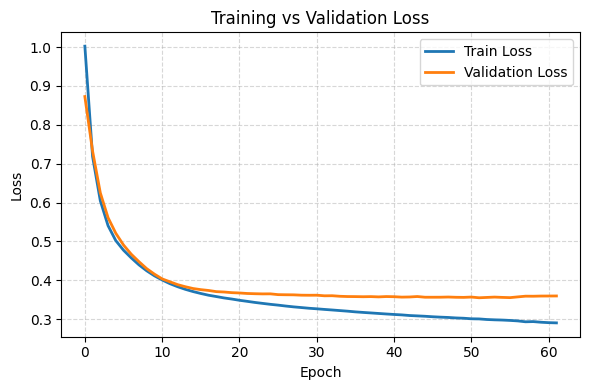

In [53]:
plot_loss_curve(history_1)

##### Predict and Evaluation

In [54]:
model_seq1 = load_model("model_seq1.keras", custom_objects={'rmse': rmse})

In [55]:
# Prediksi
y_pred_1 = model_seq1.predict(X_test).flatten()  # flatten kalau hasilnya 2D
y_pred_ori_1 = scaler_y.inverse_transform(y_pred_1.reshape(-1, 1))

# y_test = scaler_y.inverse_transform(y_test)

df_results = eval_model(y_test, y_pred_ori_1, 'model_seq1')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R squared: 0.4445
MSE      : 152.6056
RMSE     : 12.3534
MAE      : 9.1051


#### Model Functional 1

##### Define and Train Model

In [56]:
inputs = Input(shape=(input_dim,))
x = Dense(input_dim * 4, activation='relu')(inputs)
x = Dense(input_dim * 2, activation='relu')(x)
outputs = Dense(1)(x)

model_func1 = Model(inputs=inputs, outputs=outputs)

In [57]:
model_func1.compile(optimizer='adam', loss='mse', metrics=metrics)
model_func1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │         1,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,465 (9.63 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
callbacks_func1 = generate_callbacks("model_func1")

history_2 = model_func1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_func1,
    verbose=1
)

Epoch 1/100
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9469 - mae: 0.7514 - mse: 0.9469 - rmse: 0.9651
Epoch 1: val_loss improved from inf to 0.90297, saving model to model_func1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.9125 - mae: 0.7353 - mse: 0.9125 - rmse: 0.9460 - val_loss: 0.9030 - val_mae: 0.6968 - val_mse: 0.9030 - val_rmse: 0.9651 - learning_rate: 0.0010
Epoch 2/100
16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7809 - mae: 0.6583 - mse: 0.7809 - rmse: 0.8747 
Epoch 2: val_loss improved from 0.90297 to 0.77304, saving model to model_func1.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7576 - mae: 0.6486 - mse: 0.7576 - rmse: 0.8609 - val_loss: 0.7730 - val_mae: 0.6440 - val_mse: 0.7730 - val_rmse: 0.8936 - learning_rate: 0.0010
Epoch 3/100
16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6664 - mae: 0.6005 - mse: 0.6664 - rmse: 0.8073 
Epoch 3: val_loss improved from 0.77304 to 0.66991, saving model to model_func1.keras
25/25 ━━━━━━━━━━━━━━━━━━━

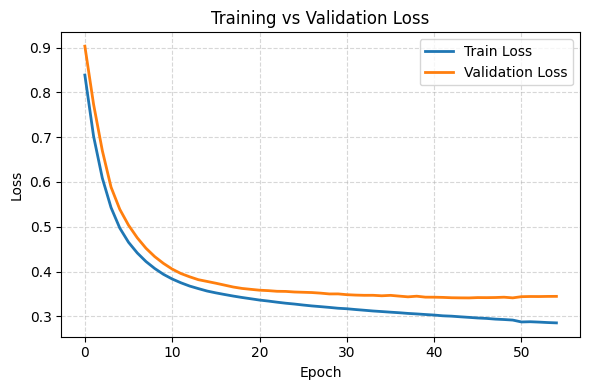

In [59]:
plot_loss_curve(history_2)

##### Predict and Evaluation

In [60]:
model_func1 = load_model("model_func1.keras", custom_objects={'rmse': rmse})

In [61]:
# Prediksi
y_pred_2 = model_func1.predict(X_test).flatten()  # flatten kalau hasilnya 2D
y_pred_ori_2 = scaler_y.inverse_transform(y_pred_2.reshape(-1, 1))

# y_test = scaler_y.inverse_transform(y_test)

new_row = eval_model(y_test, y_pred_ori_2, 'model_func1')
df_results = pd.concat([df_results, new_row], ignore_index=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R squared: 0.4617
MSE      : 147.8620
RMSE     : 12.1599
MAE      : 8.6839


#### Model Sequential 2

##### Define and Train Model

In [62]:
model_seq2 = Sequential([
    Input(shape=(input_dim,)),  # Input layer
    Dense(input_dim * 4, activation='tanh'),  # First hidden layer
    Dropout(0.3),
    Dense(input_dim * 2, activation='relu'),  # Second hidden layer
    Dropout(0.3),
    Dense(input_dim, activation='linear'),  # Third hidden layer
    Dense(1)  # Output layer
])

In [63]:
model_seq2.compile(
    optimizer='adam',
    loss='mse',
    metrics=metrics
)

model_seq2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 28)             │         1,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,857 (11.16 KB)

 Trainable params: 2,857 (11.16 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
callbacks_seq2 = generate_callbacks("model_seq2")

history_3 = model_seq2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks_seq2,
    verbose=1
)

Epoch 1/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 1.4099 - mae: 0.9439 - mse: 1.4099 - rmse: 1.1874
Epoch 1: val_loss improved from inf to 0.99059, saving model to model_seq2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.2794 - mae: 0.9147 - mse: 1.2794 - rmse: 1.1265 - val_loss: 0.9906 - val_mae: 0.7455 - val_mse: 0.9906 - val_rmse: 0.9997 - learning_rate: 0.0010
Epoch 2/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9734 - mae: 0.7602 - mse: 0.9734 - rmse: 0.9839 
Epoch 2: val_loss improved from 0.99059 to 0.92367, saving model to model_seq2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9657 - mae: 0.7556 - mse: 0.9657 - rmse: 0.9787 - val_loss: 0.9237 - val_mae: 0.7142 - val_mse: 0.9237 - val_rmse: 0.9648 - learning_rate: 0.0010
Epoch 3/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.7257 - mae: 0.6524 - mse: 0.7257 - rmse: 0.8519
Epoch 3: val_loss improved from 0.92367 to 0.86587, saving model to model_seq2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0

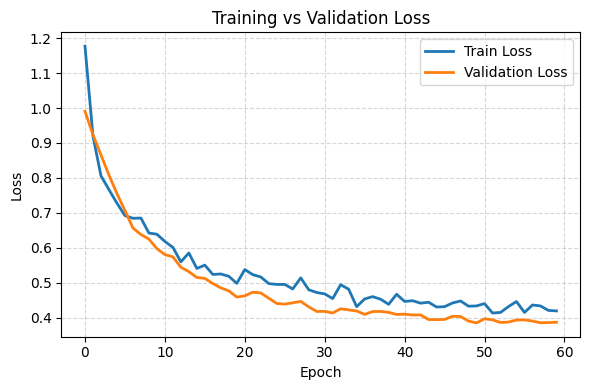

In [65]:
plot_loss_curve(history_3)

##### Predict and Evaluation

In [66]:
model_seq2 = load_model("model_seq2.keras", custom_objects={'rmse': rmse})

In [67]:
# Prediksi
y_pred_3 = model_seq2.predict(X_test).flatten()  # flatten kalau hasilnya 2D
y_pred_ori_3 = scaler_y.inverse_transform(y_pred_3.reshape(-1, 1))

# y_test = scaler_y.inverse_transform(y_test)

new_row = eval_model(y_test, y_pred_ori_3, 'model_seq2')
df_results = pd.concat([df_results, new_row], ignore_index=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R squared: 0.4317
MSE      : 156.1036
RMSE     : 12.4941
MAE      : 8.9558


#### Model Functional 2

##### Define and Train Model

In [68]:
inputs = Input(shape=(input_dim,))

# Hidden layers
x = Dense(input_dim * 3, activation='tanh')(inputs)
x = Dropout(0.3)(x)

x = Dense(input_dim * 2, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(input_dim, activation='tanh')(x)

x = Dense(input_dim // 2, activation='linear')(x)

# Output layer
outputs = Dense(1)(x)

model_func2 = Model(inputs=inputs, outputs=outputs)

In [69]:
model_func2.compile(
    optimizer='adam',
    loss='mse',
    metrics=metrics
)

model_func2.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 42)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 28)             │         1,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,353 (9.19 KB)

 Trainable params: 2,353 (9.19 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
callbacks_func2 = generate_callbacks("model_func2")

history_4 = model_func2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks_func2,
    verbose=1
)

Epoch 1/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.3506 - mae: 0.9615 - mse: 1.3506 - rmse: 1.1622
Epoch 1: val_loss improved from inf to 0.92918, saving model to model_func2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.1671 - mae: 0.8718 - mse: 1.1671 - rmse: 1.0750 - val_loss: 0.9292 - val_mae: 0.7162 - val_mse: 0.9292 - val_rmse: 0.9689 - learning_rate: 0.0010
Epoch 2/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.9157 - mae: 0.7189 - mse: 0.9157 - rmse: 0.9569
Epoch 2: val_loss improved from 0.92918 to 0.80743, saving model to model_func2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9296 - mae: 0.7409 - mse: 0.9296 - rmse: 0.9608 - val_loss: 0.8074 - val_mae: 0.6715 - val_mse: 0.8074 - val_rmse: 0.9017 - learning_rate: 0.0010
Epoch 3/100
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8400 - mae: 0.6798 - mse: 0.8400 - rmse: 0.9165
Epoch 3: val_loss improved from 0.80743 to 0.75183, saving model to model_func2.keras
13/13 ━━━━━━━━━━━━━━━━━━━

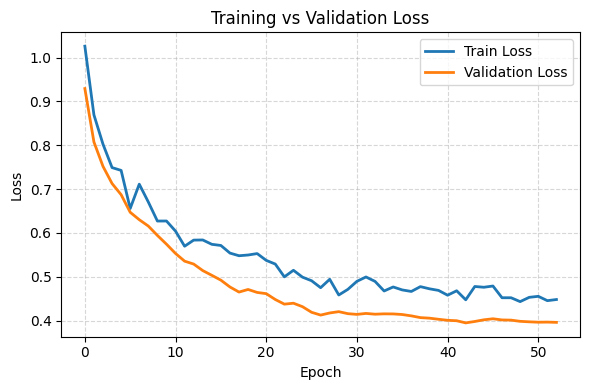

In [71]:
plot_loss_curve(history_4)

##### Predict and Evaluation

In [72]:
model_func2 = load_model("model_func2.keras", custom_objects={'rmse': rmse})

In [73]:
# Prediksi
y_pred_4 = model_func2.predict(X_test).flatten()
y_pred_ori_4 = scaler_y.inverse_transform(y_pred_4.reshape(-1, 1))

# y_test = scaler_y.inverse_transform(y_test)

new_row = eval_model(y_test, y_pred_ori_4, 'model_func2')
df_results = pd.concat([df_results, new_row], ignore_index=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R squared: 0.4205
MSE      : 159.1740
RMSE     : 12.6164
MAE      : 9.2352


### Kesimpulan

In [74]:
df_results

,model_name,r2,mse,rmse,mae
0,model_seq1,0.444459,152.605550,12.353362,9.105066
1,model_func1,0.461727,147.862004,12.159852,8.683924
2,model_seq2,0.431725,156.103617,12.494143,8.955778
3,model_func2,0.420547,159.174014,12.616418,9.235222
